In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline, interp1d, PchipInterpolator
from scipy.interpolate import LSQUnivariateSpline
import warnings



"""
Energy dissipation function
Preparation:
Copy values provided by Semeter and Kamalabadi
Fit it with LSQUnivariateSpline to get rid of wiggles (only positive values of s/R, negative ones are not expected).
Evaluate calling the resulting function.
"""

#raw data Semeter and Kamalabadi, 2005:
#add some values at s/R > 0.950 (all lamdba(s/R>0.95) = 0) to smoothen the transition, get rid of negative energy dissipation values
E_diss_table = np.array([
               [-0.525, 0.000], [-0.500, 0.006], [-0.475, 0.020], [-0.450, 0.027], [-0.425, 0.042], [-0.400, 0.058], [-0.375, 0.069], 
               [-0.350, 0.091], [-0.325, 0.123], [-0.300, 0.145], [-0.275, 0.181], [-0.250, 0.214], [-0.225, 0.248], [-0.200, 0.313],
               [-0.175, 0.360], [-0.150, 0.431], [-0.125, 0.499], [-0.100, 0.604], [-0.075, 0.728], [-0.050, 0.934], [-0.025, 1.237], 
               [ 0.000, 1.686], [ 0.025, 1.995], [ 0.050, 2.063], [ 0.075, 2.024], [ 0.100, 1.946], [ 0.125, 1.846], [ 0.150, 1.761], 
               [ 0.175, 1.681], [ 0.200, 1.596], [ 0.225, 1.502], [ 0.250, 1.421], [ 0.275, 1.346], [ 0.300, 1.260], [ 0.325, 1.190], 
               [ 0.350, 1.101], [ 0.375, 1.043], [ 0.400, 0.972], [ 0.425, 0.888], [ 0.450, 0.834], [ 0.475, 0.759], [ 0.500, 0.689], 
               [ 0.525, 0.636], [ 0.550, 0.567], [ 0.575, 0.504], [ 0.600, 0.450], [ 0.625, 0.388], [ 0.650, 0.334], [ 0.675, 0.282], 
               [ 0.700, 0.231], [ 0.725, 0.187], [ 0.750, 0.149], [ 0.775, 0.113], [ 0.800, 0.081], [ 0.825, 0.058], [ 0.850, 0.037], 
               [ 0.875, 0.023], [ 0.900, 0.010], [ 0.925, 0.002], [ 0.950, 0.000] 
            , [ 0.955, 0.000], [ 0.960, 0.000], [ 0.965, 0.000], [ 0.970, 0.000], [ 0.975, 0.000]
            , [ 0.980, 0.000], [ 0.985, 0.000], [ 0.990, 0.000], [ 0.995, 0.000], [ 1    , 0.000] 
                ])

#lsq fit using splines of order 5, using 4 datapoints to fit
i1 = 21
knots = np.arange(0.01, 1, 0.1)
knots = np.append(knots, [0.996]) #smoothen transition to 0
spl = LSQUnivariateSpline(E_diss_table[i1:, 0], E_diss_table[i1:, 1], knots, k = 5)
cs = CubicSpline(E_diss_table[:, 0], E_diss_table[:, 1], bc_type = 'clamped')


def E_diss_func(s, R):
    """
    Returns the energy dissipation function evaluated at s/R, (as defined in Semeter and Kamalabadi)
    by looking up the value in the E_diss_table and interpolating.
    R is the range of an electron in air with energy E.
    
    Parameters:
    s: scattering depth along the magnetic field: s = sec(I) * int(density dy)(0..inf), I: inclination angle of B
        scalar
    E: Energy of electron (eV)
        scalar
    
    Returns:
    e_diss: The energy dissipation function evaluated at s/R.
        scalar
    """
    if s/R < 0: 
        warnings.warn("s/R < 0 encountered in Energy dissipation function.")
        if s/R < -0.525:
            e_diss = 0
        else:
            #index = int(np.floor(s/R/0.025 + 21))
            #print(s/R, E_diss_table[index, 0])
            #interpolation
            e_diss = cs(s/R)
    elif s/R >= 0.9486: #to avoid negative energy dissipation
        e_diss = 0
    else:
        e_diss = spl(s/R)
    if e_diss < 0: raise Exception('The dissipation function returns a negative value:', e_diss)
    return e_diss
    

def e_range(E):
    """
    Calculates the (density normalized) range of an electron in air in kg/m^2
    Actual distance d = R / density
    
    Parameters:
    E: Electron energy (eV)
        scalar or ndarray
    
    Returns:
    R: The density normalized range [kg m^-2]
        same shape as E
    """
    kE = E/1000
    R = (4.3 + 53.6 * (kE**(1.67)) - 0.038 * (kE**(-0.7)))*1e-6 #kg m-2
    return R


def scattering_depth_sh(rho, H, z, z_lower, inc_B):
    """
    Returns the scatterig depth at distance z, projected along the magnetic field
    Using the scale height sh(m(z), g(z), T(z)) to compute density variations, including intergration to +inf
    
    Parameters:
    rho: mass density profile (discretized by z)
        ndarray [1 x n]
    H: scale height profile (discretized by z)
        ndarray [1 x n]
    z: heights of the profile (discretization parameter of rho and H)
        ndarray [1 x n]
    z_lower: lower integration boundary 
        scalar
    I: Inclination angle
        scalar
       
    Returns:
    scattering depth s in [kg m^-2]
    """
    #filtering in height:
    
    ind = z>=z_lower
    alt = z[ind]
    m_density = rho[ind]
    h_scale = H[ind]
        
    delta_alt = alt[1:] - alt[:-1]
    #s = 1/np.cos(inc_B) * np.sum(m_density[:-1] * delta_alt)
    #implicitly, above code asks for a high resolution in height.
    #if not enough measurements of rho in height, possible to interpolate using scale height
    #formula using scale heigh H: sum(rho(z) * delta_z) => sum_i[int(rho(z) dz)(z_i .. z_i+1)]
    #with int(rho(z) dz)(z_i .. z_i+1) = rho_i * H_i * [exp(-(z_i+1 - z_i)/H_i) - 1]
    #where H_i is the scale height at altidute z_i, and assuemd to be constant in z_i.
    delta_alt = np.append(delta_alt, np.inf)
    s = np.sum(m_density * h_scale * (1 - np.exp(-delta_alt/h_scale)))
    if(z_lower > z[-1]):
        s = rho[-1] * H[-1] * np.exp(-(z_lower - z[-1])/H[-1])
    elif z_lower < alt[0]:
        s = m_density[0] * h_scale[0] * (1 - np.exp(-(alt[0] - z_lower)/h_scale[0]))
    s = s/np.cos(inc_B)
    return s


def scattering_depth(rho, z, z_lower, inc_B):
    """
    Returns the scatterig depth at distance z, projected along the magnetic field
    Only does a simple sum. If more sophisticated procedures are needed, rewrite,
    or just provide higher resolved z, rho(z)
    
    Parameters:
    rho: mass density profile (discretized by z)
        ndarray [1 x n]
    z: heights of the profile (discretization parameter of rho and H)
        ndarray [1 x n]
    z_lower: lower integration boundary 
        scalar
    I: Inclination angle
        scalar
    res: desired height resolution. rho is interpolated to be resolved in height according to res.   
    
    Returns:
    scattering depth s in [kg m^-2]
    """
    #def interp_rho(d):
    #    return np.exp(interp1d(z, np.log(rho), fill_value = 'extrapolate')(d))
    
    ind = z>=z_lower
    alt = z[ind]
    m_density = rho[ind]
    
    if z_lower != alt[0]: 
        s0 = m_density[0] * (alt[0] - z_lower)
        
    else: s0 = 0
    
    delta_alt = alt[1:] - alt[:-1]
    s = 1/np.cos(inc_B) * (np.sum(m_density[:-1] * delta_alt) + s0)
    return s


def interp_z_md(z, rho, z_min, z_max, res):
    zp = np.arange(z_min, z_max, res)
    return zp, np.exp(interp1d(z, np.log(rho), fill_value = 'extrapolate')(zp))


def interp_md(z, rho, zp):
    """
    Interpolates the mass density in an exponential fashion along the height z.
    
    Parameters:
    z: list of heights along which the mass density is known
        ndarray
    rho: mass density as an array along heights z
        ndarray
    zp: point to evaluate the interpolated function at.
        ndarray
        
    Returns:
    The mass density at the heights zp
    """
    return np.exp(interp1d(z, np.log(rho), fill_value = 'extrapolate')(zp))


def interp_md_cs(z, rho, zp):
    """
    Interpolates the mass density in an exponential fashion along the height z, using CubicSplines
    only extrapolation to lower values is done using interp1d (linear interploation)
    
    Parameters:
    z: list of heights along which the mass density is known
        ndarray
    rho: mass density as an array along heights z
        ndarray
    zp: point to evaluate the interpolated function at.
        ndarray
        
    Returns:
    The mass density at the heights zp
    """
    int_cs  = np.exp(CubicSpline(z, np.log(rho))(zp))
    int_lin = np.exp(interp1d(z[:2], np.log(rho[:2]), fill_value = 'extrapolate')(zp))
    md = np.array([*int_lin[zp<80000], *int_cs[zp>=80000]])
    return md

def interp_md_pchip(z, rho, zp):
    """
    Interpolates the mass density in an exponential fashion along the height z, using CubicSplines
    only extrapolation to lower values is done using interp1d (linear interploation)
    
    Parameters:
    z: list of heights along which the mass density is known
        ndarray
    rho: mass density as an array along heights z
        ndarray
    zp: point to evaluate the interpolated function at.
        ndarray
        
    Returns:
    The mass density at the heights zp
    """
    #alike
    #self.N2.density  = np.exp(PchipInterpolator(z_msis, np.log(n_n2_msis))(z_model))
    return np.exp(PchipInterpolator(z, np.log(rho))(zp))


def e_production(z_min, z_max, res_fm, z_sd_min, z_sd_max, res_sd, e_bin_lims, z_msis, mass_density, inc_B):
    """ 
    builds a forward model for electron production due to a differential flux into the ionosphere accoring
    to Semeter and Kamalabadi (2005).
    
    Parameters:
    z_min: lower altitude of forward model IN METERS
        scalar
    z_max: upper altudute of forward model IN METERS
        scalar
    res_fm: resolution of the forward model in height, used to interpolate density IN METERS
        scalar
    z_sd_min: lower altitude to calculate scattering depth IN METERS
        scalar
    z_sd_max: upper altitude to calculate scattering depth IN METERS
                it is a good idea to provide a z_sd_max larger than z_max (eg. +200km), as the mass density is assumed to be 0 above that.
                This allows the scattering depth to catch up to reasonable levels at z_max.
                The mass density is extrapolated if not provided at these heights.
        scalar
    res_sd: resolution in height of density in height for calculation of scattering depth IN METERS
        scalar
    e_bin_lims: limits of energy bins
        ndarray
    z_msis: height data of mass_density (height information)
        ndarray
    mass_density: mass_density resolved in height, height given z_msis
        ndarray
    inc_B: inclination of the magnetic field.
        scalar
        
    Returns:
    fm: the forward model and the corresponding heights z_fm 
        ndarray
    z_fm: height, according to z_min, z_max and res_fm
        ndarray
    """
    
    z_fm = np.arange(z_min, z_max, res_fm)
    md_fm = interp_md_pchip(z_msis, mass_density, z_fm)
    
    z_sd = np.arange(z_sd_min, z_sd_max, res_sd)
    md_sd = interp_md_pchip(z_msis, mass_density, z_sd)
    
    e_bin_mean = (e_bin_lims[1:] + e_bin_lims[:-1]) / 2
    e_bin_width = e_bin_lims[1:] - e_bin_lims[:-1]
    
    fm = np.zeros([len(z_fm), len(e_bin_mean)])
    for i in range(len(z_fm)):
        if i/len(z_fm)%0.1 == 0: print(i/len(z_fm)) 
        #use interpolated values for mass density (mdp) and height (zp)
        scat_d = scattering_depth(md_sd, z_sd, z_fm[i], inc_B)
        for j in range(len(e_bin_mean)):
            ran = e_range(e_bin_mean[j])
            energy_diss = E_diss_func(scat_d, ran)
            fm[i, j] = energy_diss * md_fm[i] * e_bin_mean[j] * e_bin_width[j] / (35.5 * ran)
    return fm, z_fm

Integration of Energy dissipation function -1..1 =  0.9996537020815597


/var/folders/gg/y13kmxq903n_0k8qcq3bqf4r0000gp/T/ipykernel_5165/1318408492.py:58: UserWarning: s/R < 0 encountered in Energy dissipation function.
  warnings.warn("s/R < 0 encountered in Energy dissipation function.")
/var/folders/gg/y13kmxq903n_0k8qcq3bqf4r0000gp/T/ipykernel_5165/1318408492.py:58: UserWarning: s/R < 0 encountered in Energy dissipation function.
  warnings.warn("s/R < 0 encountered in Energy dissipation function.")


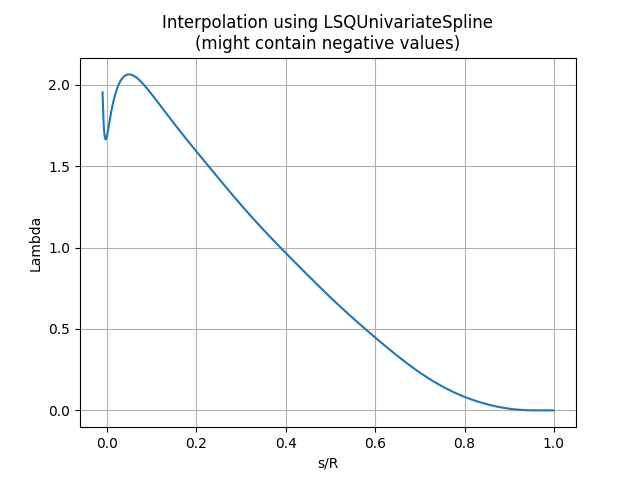

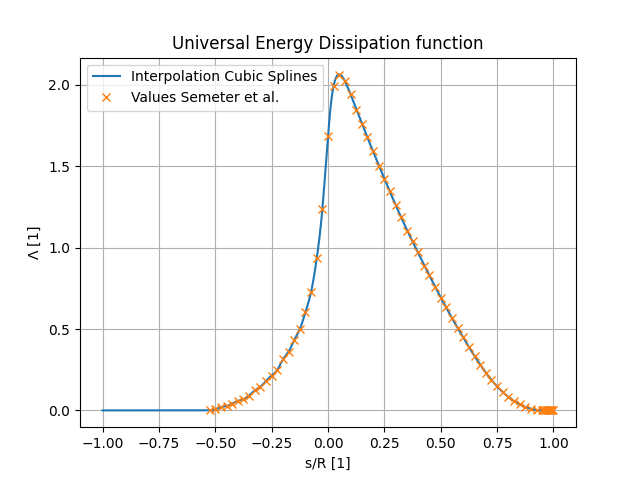

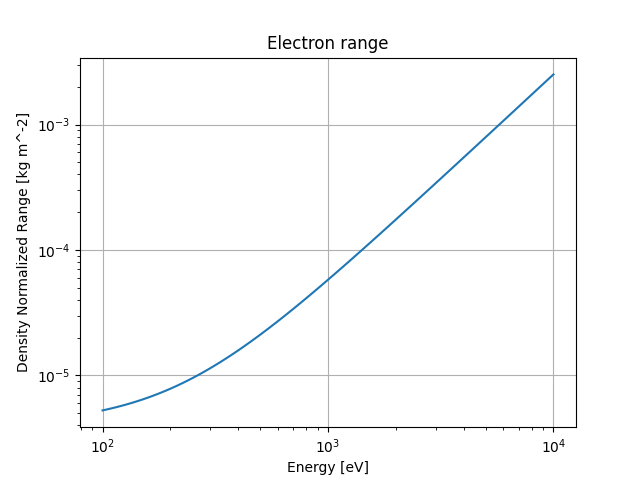

In [13]:
printing = 0

%matplotlib widget

#check if energy dissipation adds up to 1:
if printing:
    res = 0.000001
    res = 0.001
    s = np.arange(-1, 1, res)
    e_diss = list(map(E_diss_func, s, np.ones(len(s))))
    print('Integration of Energy dissipation function -1..1 = ', np.sum(e_diss) * res)


#Show interpolation of positive values (spl)
if printing: 
    plt.figure()
    s = np.arange(-0.01, 1, 0.001)
    plt.title('Interpolation using LSQUnivariateSpline\n(might contain negative values)')
    plt.plot(s, spl(s))
    #plt.plot(E_diss_table[i1:, 0], E_diss_table[i1:, 1], 'x')
    plt.grid()
    plt.xlabel('s/R')
    plt.ylabel('Lambda')
    
#check shape of E_diss_func (using spl for positive values, cs for negative)
if printing:
    s = np.arange(-1, 1, 0.001)
    e_diss = list(map(E_diss_func, s, np.ones(len(s))))
    plt.figure()
    plt.plot(s, e_diss, label = 'Interpolation Cubic Splines')
    plt.plot(E_diss_table[:, 0], E_diss_table[:, 1], 'x', label = 'Values Semeter et al.')
    plt.legend()
    plt.title('Universal Energy Dissipation function')
    plt.xlabel('s/R [1]')
    plt.ylabel('$\Lambda$ [1]')
    plt.grid()
    
#plot electron range as a function of energy
if printing:
    e = np.logspace(2, 4 , 100)
    plt.figure()
    plt.plot(e, e_range(e))
    plt.xscale('log')
    plt.yscale('log')
    plt.title('Electron range')
    plt.xlabel('Energy [eV]')
    plt.ylabel('Density Normalized Range [kg m^-2]')
    plt.grid()
    


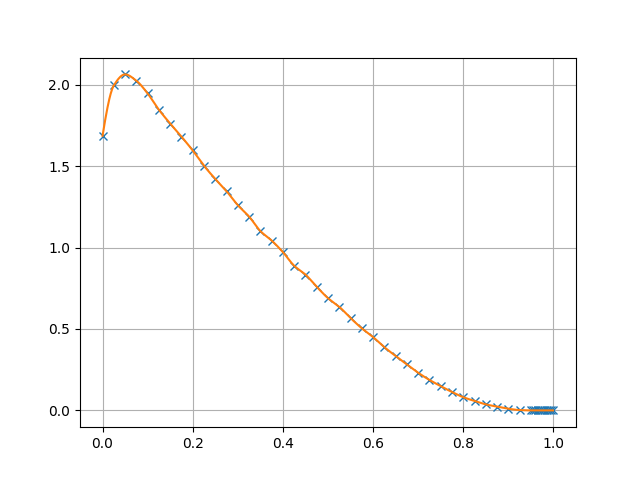

In [14]:
if printing:
    %matplotlib widget
    efit = E_diss_table[E_diss_table[:, 0] >= 0]

    x = np.arange(0, 1, 0.001)
    plt.figure()
    plt.plot(efit[:, 0], efit[:, 1], 'x')
    plt.plot(x, (PchipInterpolator(efit[:, 0], efit[:, 1])(x)), label = 'exp(pchip(log))')
    plt.plot()
    plt.grid()
    
#not used, due to wobbly nature of pchipinterp.

/var/folders/gg/y13kmxq903n_0k8qcq3bqf4r0000gp/T/ipykernel_5165/1318408492.py:58: UserWarning: s/R < 0 encountered in Energy dissipation function.
  warnings.warn("s/R < 0 encountered in Energy dissipation function.")


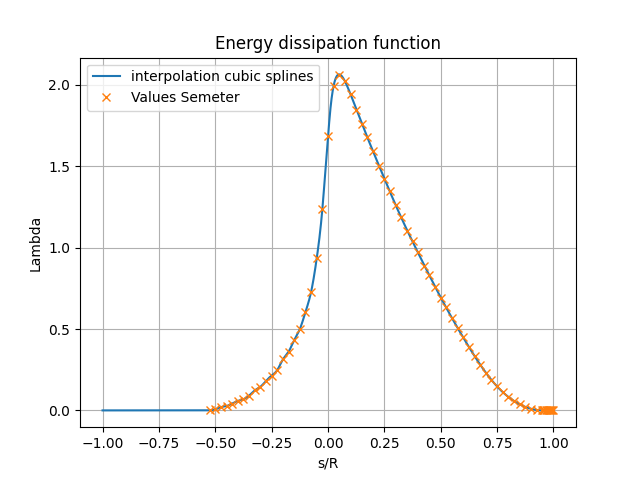

In [15]:
if printing:
    s = np.arange(-1, 1, 0.001)
    e_diss = list(map(E_diss_func, s, np.ones(len(s))))
    plt.figure()
    plt.plot(s, e_diss, label = 'interpolation cubic splines')
    plt.plot(E_diss_table[:, 0], E_diss_table[:, 1], 'x', label = 'Values Semeter')
    plt.legend()
    plt.title('Energy dissipation function')
    plt.xlabel('s/R')
    plt.ylabel('Lambda')
    plt.grid()